In [151]:
# system
from datetime import datetime
from datetime import timedelta

# data processing and plotting
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ml/dl
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [152]:
df = pd.read_csv('../data/iceprod.csv')
df.head()

,DATE,Icecream
0,1/1/1972,59.9622
1,2/1/1972,67.0605
2,3/1/1972,74.2350
3,4/1/1972,78.1120
4,5/1/1972,84.7636


## Preprocessing

In [153]:
# rename columns
df.columns = ['date', 'production']

# convert to date
df.date = pd.to_datetime(df.date)

# use date as df index
df.set_index('date', inplace=True)
df.head()

,production
date,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


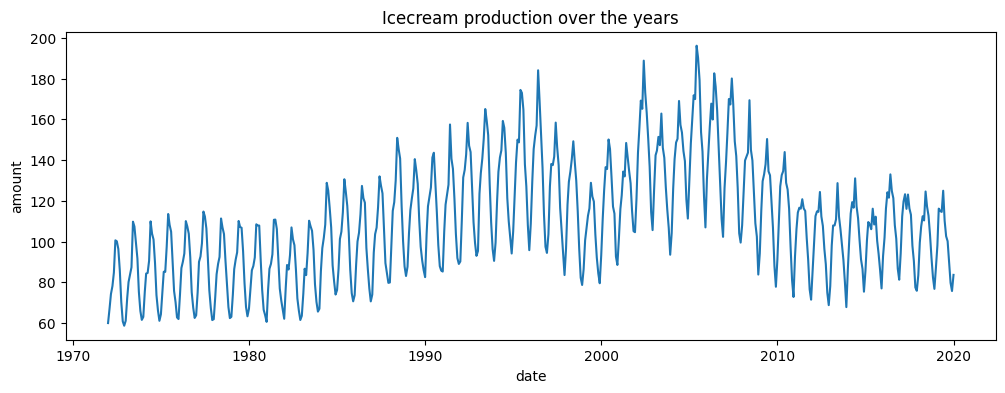

In [154]:
plt.figure(figsize=(12, 4))
plt.plot(df)
plt.ylabel('amount')
plt.xlabel('date')
plt.title('Icecream production over the years')
plt.show()

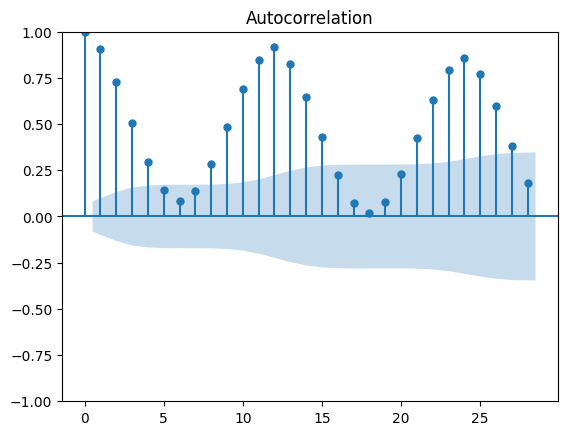

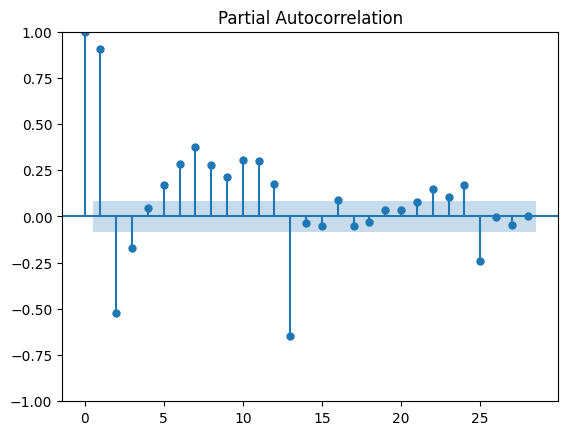

In [155]:
plot_acf(df)
plot_pacf(df)
plt.show()

ACF plot confirms: seasonality is present in the data (wave)

In [156]:
# take difference
df_1diff = df.diff()[1:]
df_1diff.head()

,production
date,
1972-02-01,7.0983
1972-03-01,7.1745
1972-04-01,3.8770
1972-05-01,6.6516
1972-06-01,15.8324


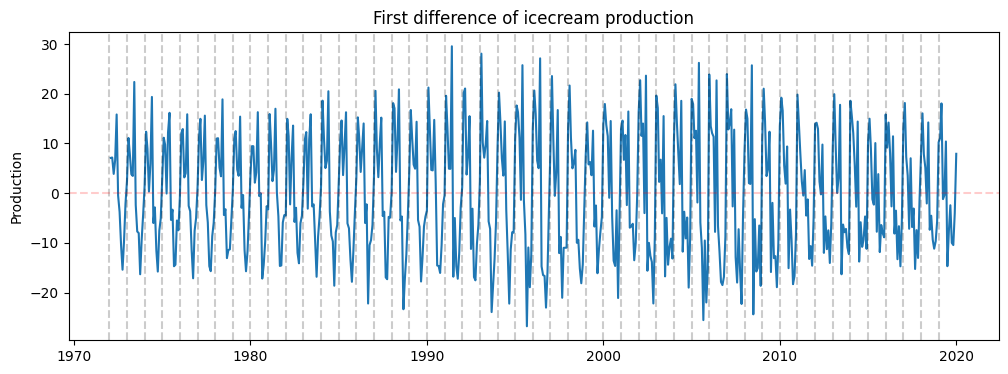

In [157]:
plt.figure(figsize=(12, 4))
plt.plot(df_1diff)
plt.title('First difference of icecream production')
plt.ylabel('Production')
for year in range(df.index[0].year,df.index[-1].year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(df_1diff.mean().values, color='r', alpha=0.2, linestyle='--')
plt.show()

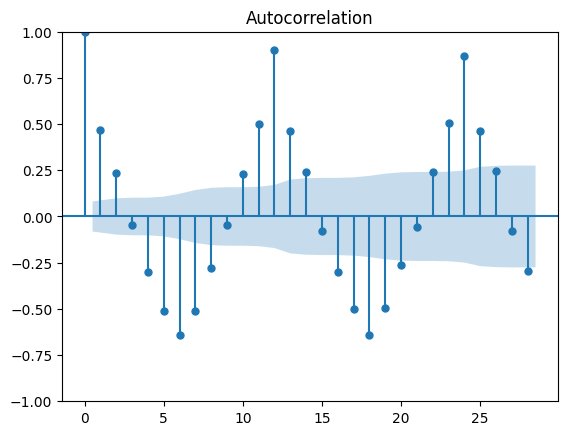

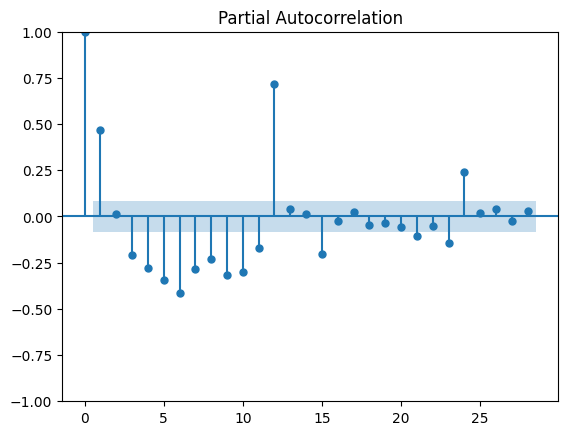

In [158]:
plot_acf(df_1diff)
plot_pacf(df_1diff)
plt.show()

In [159]:
# picking params
ma_params = [1, 6]
ar_params = [1, 6]

## Training

### ARIMA

In [160]:
# select data upto 2015
start_date, end_date = datetime(1972, 1, 1), datetime(2019, 1, 1)
df_train = df_1diff[:end_date]
df_test = df_1diff[end_date+timedelta(days=1):]

In [161]:
# define model
model = ARIMA(df_train, order=(1, 0, 6)).fit()
model

c:\Users\kiril\.pyenv\pyenv-win\versions\3.9.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kiril\.pyenv\pyenv-win\versions\3.9.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kiril\.pyenv\pyenv-win\versions\3.9.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [162]:
# summary
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                  564
Model:                 ARIMA(1, 0, 6)   Log Likelihood               -2030.765
Date:                Sat, 27 Jan 2024   AIC                           4079.531
Time:                        15:29:42   BIC                           4118.546
Sample:                    02-01-1972   HQIC                          4094.761
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0439      0.085      0.518      0.605      -0.122       0.210
ar.L1         -0.1595      0.116     -1.375      0.169      -0.387       0.068
ma.L1          0.3703      0.103      3.604      0.0

In [163]:
# get prediction start and end dates
pred_start_date = df_test.index[0]
pred_end_date = df_test.index[-1]

In [164]:
# get the predictions and residuals
predictions = model.predict(start=pred_start_date, end=pred_end_date)
residuals = df_test.production - predictions

In [165]:
predictions.head()

2019-02-01    5.250317
2019-03-01    5.642497
2019-04-01    3.410937
2019-05-01    3.268187
2019-06-01    0.507446
Freq: MS, Name: predicted_mean, dtype: float64

In [166]:
df_test.head()

,production
date,
2019-02-01,11.1128
2019-03-01,18.0602
2019-04-01,-1.2015
2019-05-01,-0.4090
2019-06-01,10.3992


In [167]:
residuals.head()

date
2019-02-01     5.862483
2019-03-01    12.417703
2019-04-01    -4.612437
2019-05-01    -3.677187
2019-06-01     9.891754
dtype: float64

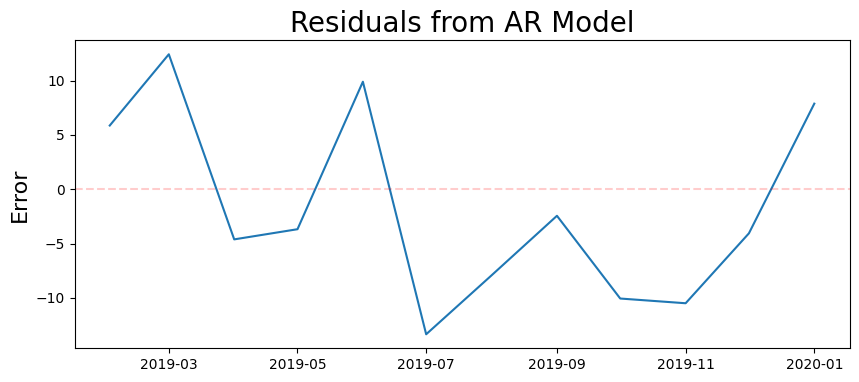

In [168]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)
plt.show()

Text(0, 0.5, 'Sales')

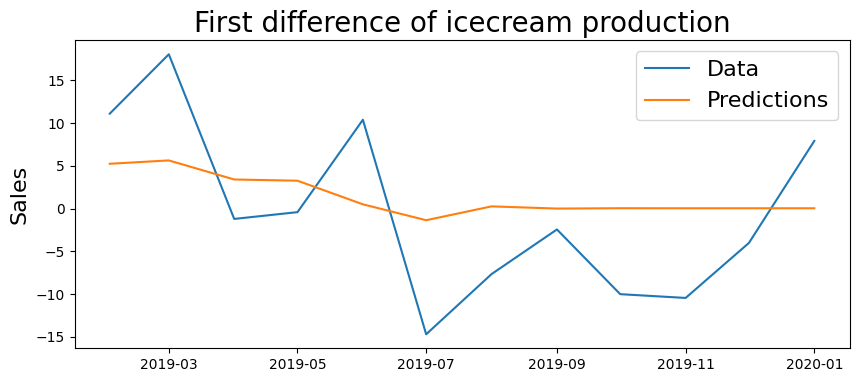

In [169]:
plt.figure(figsize=(10,4))
plt.plot(df_test)
plt.plot(predictions)
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.title('First difference of icecream production', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [170]:
mae = mean_absolute_error(df_test, predictions)
rmse = np.sqrt(mean_squared_error(df_test, predictions))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 7.72
Root Mean Squared Error: 8.45


### auto_arima

In [171]:
model = auto_arima(df_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(df_train)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3826.707, Time=0.53 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4400.668, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4260.335, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4295.114, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4398.677, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4253.097, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=3807.783, Time=0.56 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=4043.646, Time=0.24 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=3782.362, Time=0.63 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=3995.638, Time=0.32 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=3790.323, Time=0.66 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=3804.054, Time=0.63 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=3

ARIMA(order=(5, 0, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [172]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  564
Model:               SARIMAX(5, 0, 3)   Log Likelihood               -1865.901
Date:                Sat, 27 Jan 2024   AIC                           3749.803
Time:                        15:29:56   BIC                           3788.818
Sample:                    02-01-1972   HQIC                          3765.032
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5462      0.042     13.007      0.000       0.464       0.629
ar.L2          0.5333      0.055      9.680      0.000       0.425       0.641
ar.L3         -0.6103      0.042    -14.573      0.0

In [173]:
predictions = model.predict(n_periods=df_test.shape[0])
residuals = df_test.production - predictions

In [174]:
predictions

2019-02-01    12.116156
2019-03-01     7.746126
2019-04-01    11.431703
2019-05-01     5.263690
2019-06-01     1.443678
2019-07-01    -6.979965
2019-08-01    -8.276525
2019-09-01   -12.607900
2019-10-01    -8.686822
2019-11-01    -7.187064
2019-12-01     1.045071
2020-01-01     4.182390
Freq: MS, dtype: float64

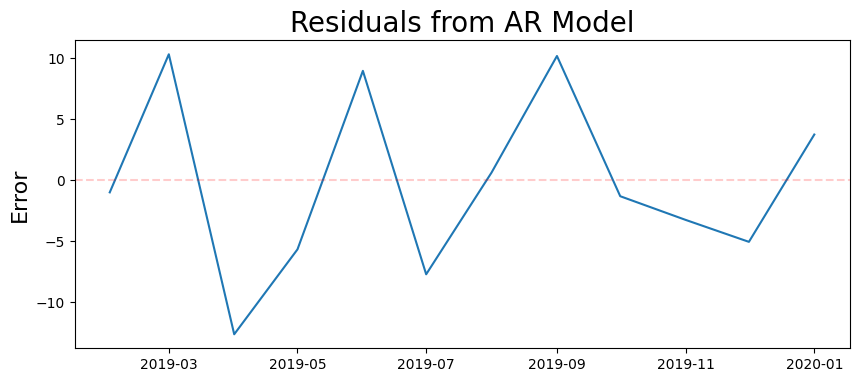

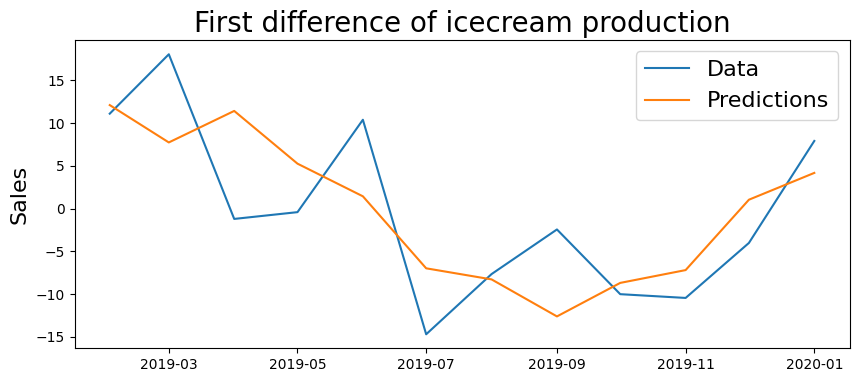

In [175]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df_test)
plt.plot(predictions)
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.title('First difference of icecream production', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.show()

In [176]:
mae = mean_absolute_error(df_test, predictions)
rmse = np.sqrt(mean_squared_error(df_test, predictions))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 5.87
Root Mean Squared Error: 7.04


## Simulation

### Utils

In [179]:
# appends row to time series dataframe (assumes date is used as index)
def df_append_row(df: pd.DataFrame, production: float):
    return pd.concat([
        df, 
        pd.DataFrame({df.index.name: df.index[-1]+pd.DateOffset(months=1), df.columns[0]: production}, index=[0]).set_index(df.index.name)
    ])


# runs the training process (unsupervised, without correcting for true value, but using its predicted value)
def run_training_unsupervised(df_train: pd.DataFrame):
    # train the model
    model = auto_arima(df_train, trace=False, error_action='ignore', suppress_warnings=True)
    model.fit(df_train)
    
    # predict
    y_pred = model.predict(n_periods=1)
    
    # add it to the training dataset
    df_train = df_append_row(df_train, y_pred[0])
    
    return df_train
    
    
def run_simulation():
    pass 

In [199]:
df_sim = df_train
for i in range(df_test.shape[0]):
    print(f'iteration {i:2d} | {df_test.index[i]}')
    df_sim = run_training_unsupervised(df_sim)


iteration  0 | 2019-02-01 00:00:00
iteration  1 | 2019-03-01 00:00:00
iteration  2 | 2019-04-01 00:00:00
iteration  3 | 2019-05-01 00:00:00
iteration  4 | 2019-06-01 00:00:00
iteration  5 | 2019-07-01 00:00:00
iteration  6 | 2019-08-01 00:00:00
iteration  7 | 2019-09-01 00:00:00
iteration  8 | 2019-10-01 00:00:00
iteration  9 | 2019-11-01 00:00:00
iteration 10 | 2019-12-01 00:00:00
iteration 11 | 2020-01-01 00:00:00


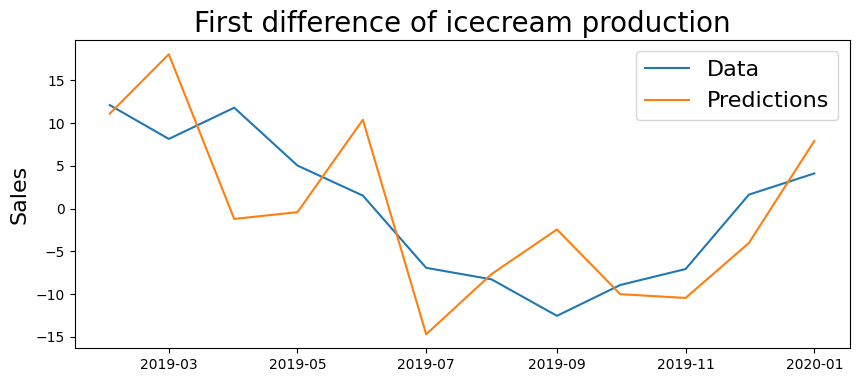

In [196]:
plt.figure(figsize=(10,4))
plt.plot(df_sim[df_train.index[-1]:][1:])
plt.plot(df_test)
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.title('First difference of icecream production', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.show()

In [198]:
mae = mean_absolute_error(df_test, df_sim[df_train.index[-1]:][1:])
rmse = np.sqrt(mean_squared_error(df_test, df_sim[df_train.index[-1]:][1:]))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 5.89
Root Mean Squared Error: 7.06
